In [1]:
import classy as Class
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from astropy.cosmology import Planck15 as cosmo
from IPython.display import display, clear_output

######################################################
#  Setting fiducial parameters
#  Planck18 TT,TE,EE+lowE+lensing+BAO
######################################################

ln10e10As = 3.047
As = np.exp(ln10e10As)/(10**10)


standard_params = {
    "omega_b": 0.02242,
    "omega_cdm": 0.11933,
    "n_s": 0.9665,
    "tau_reio": 0.0561,
    "ln10^{10}A_s": ln10e10As,
    "H0": 67.66
}

######################################################
#  Setting up plots
######################################################

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = [8.0,6.0]

plancklike=True
ll_max = 2500
linear_sampling = 20000  #number of timesteps during recombination

common_settings = {'output' : 'tCl,pCl,lCl',
                   # LambdaCDM parameters
                   'H0':standard_params["H0"],
                   'omega_b':standard_params["omega_b"],
                   'omega_cdm':standard_params["omega_cdm"],
                   'ln10^{10}A_s': standard_params["ln10^{10}A_s"],
                   'n_s':standard_params["n_s"],
                   'tau_reio': standard_params["tau_reio"],
                   'thermodynamics_verbose': 0,
                   'input_verbose': 0,
                   'lensing': 'yes',
                   'xe_pert_type': 'none'
                   }
                   
M = Class.Class()
M.set(common_settings)

True

In [2]:
M.compute()

# Creating fiducial $C^{XX}_\ell$

In [3]:
Tcmb = M.T_cmb()*10**6 #cmb temp in micro kelvin
#Tcmb=1.0
ll = np.arange(2, ll_max+1)
muK2 = (Tcmb)**2
tt_fid = muK2*M.lensed_cl(ll_max)['tt'][2:]
te_fid = muK2*M.lensed_cl(ll_max)['te'][2:]
ee_fid = muK2*M.lensed_cl(ll_max)['ee'][2:]

fiducials = {}

tt_dict = {}
te_dict = {}
ee_dict = {}

for i,Cl in enumerate(tt_fid):
    tt_dict[i+2] = Cl
    te_dict[i+2] = te_fid[i]
    ee_dict[i+2] = ee_fid[i]
    fiducials.update({'tt': tt_dict, 'te': te_dict, 'ee': ee_dict})

# Constructing the Covariance Matrix

In [5]:
######################################################
#   Noise parameters from arxiv.org/abs/1807.06207
#   Table 12
######################################################
noise_parameters = {'beam_FWHM_100_arcmin' : 9.68,
                    #'beam_FWHM_143_arcmin' : 7.3,
                    #'beam_FWHM_217_arcmin' : 4.90,
                    'beam_FWHM_143_arcmin' : 5.,
                    'beam_FWHM_217_arcmin' : 2,
                    'weight_inv_T_100' : 1.52e-4,
                    'weight_inv_P_100' : 2.94e-4,
                    #'weight_inv_T_143' : 0.36e-4,
                    'weight_inv_T_143' : 0.36e-16,
                    #'weight_inv_P_143' : 1.61e-4,
                    'weight_inv_P_143' : 3.70e-4,
                    #'weight_inv_T_217' : 0.78e-4,
                    'weight_inv_T_217' : 0.78e-4,
                    #'weight_inv_P_217' : 3.25e-4,
                    'weight_inv_P_217' : 3.77e-4,
                    'use_100' : False,
                    'use_143' : True,
                    'use_217' : True,
                    }  

def construct_covariance(fiducial_arrays, ells, noise_parameters):
    arcmin_to_radians = 1./3438
    factor = np.sqrt(8*np.log(2))
    #factor = 1.0 

    T_channels = []
    P_channels = []
    if noise_parameters['use_100']:
        #convert from arcmin -> radians, then divide by 2.355 to get sigma from FWHM
        beam_width_100 = (noise_parameters['beam_FWHM_100_arcmin']*arcmin_to_radians)/factor
        B2_l = np.exp(-ells*(ells+1)*beam_width_100**2)
        T_channels.append(noise_parameters['weight_inv_T_100']/B2_l)
        P_channels.append(noise_parameters['weight_inv_P_100']/B2_l)
    if noise_parameters['use_143']:
        #convert from arcmin -> radians, then divide by 2.355 to get sigma from FWHM
        beam_width_143 = (noise_parameters['beam_FWHM_143_arcmin']*arcmin_to_radians)/factor
        B2_l = np.exp(-ells*(ells+1)*beam_width_143**2)
        T_channels.append((noise_parameters['weight_inv_T_143']/B2_l)**-1)
        P_channels.append((noise_parameters['weight_inv_P_143']/B2_l)**-1)
    if noise_parameters['use_217']:
        beam_width_217 = (noise_parameters['beam_FWHM_217_arcmin']*arcmin_to_radians)/factor
        B2_l = np.exp(-ells*(ells+1)*beam_width_217**2)
        T_channels.append((noise_parameters['weight_inv_T_217']/B2_l)**-1)
        P_channels.append((noise_parameters['weight_inv_P_217']/B2_l)**-1)
    
    if not T_channels:
        Nl_T = 0.0
    else:
        Nl_T = (np.sum(T_channels, axis=0))**(-1.)
    
    if not P_channels:
        Nl_P = 0.0
    else:
        Nl_P = (np.sum(P_channels, axis=0))**(-1.)

    print(Nl_T)
    print(Nl_P)
    
    tt_fid = np.fromiter(fiducials['tt'].values(), dtype=float)
    te_fid = np.fromiter(fiducials['te'].values(), dtype=float)
    ee_fid = np.fromiter(fiducials['ee'].values(), dtype=float)

    row1 = np.stack([(tt_fid+Nl_T)**2, te_fid**2, (tt_fid+Nl_T)*te_fid], axis=1)
    row2 = np.stack([te_fid**2, (ee_fid+Nl_P)**2, te_fid*(ee_fid+Nl_P)], axis=1)
    row3 = np.stack([(tt_fid+Nl_T)*te_fid, te_fid*(ee_fid+Nl_P), 0.5*(te_fid**2 + (tt_fid+Nl_T)*(ee_fid+Nl_P))], axis=1)

    sigma = np.stack([row1, row2, row3], axis=1)
    fsky = 0.8
    for i, ell in enumerate(ll):
        sigma[i]*=(2./((2*ell + 1)))/fsky

    return sigma

error_covariance = construct_covariance(fiducials, ll, noise_parameters=noise_parameters)

[3.60000824e-17 3.60001648e-17 3.60002746e-17 ... 3.89391528e-16
 3.90134563e-16 3.90879315e-16]
[0.00018673 0.00018673 0.00018673 ... 0.00048495 0.00048519 0.00048543]


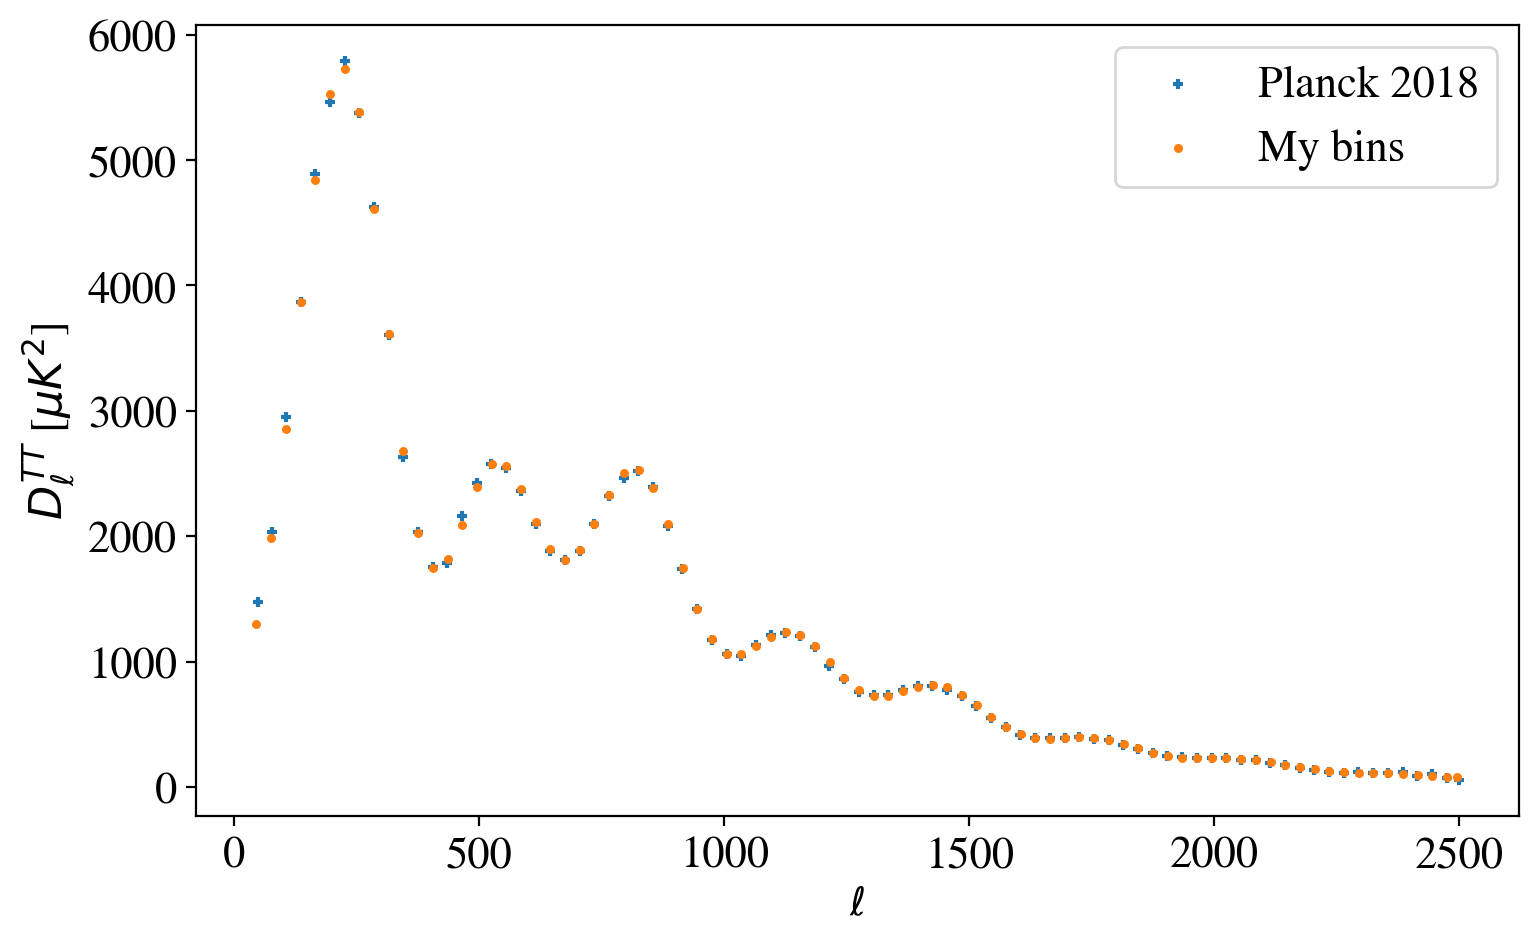

In [6]:
import math

TT_file = "/Users/gabe/projects/recombination/data/planck/COM_PowerSpect_CMB-TT-binned_R3.01.txt"
TE_file = "/Users/gabe/projects/recombination/data/planck/COM_PowerSpect_CMB-TE-binned_R3.02.txt"
EE_file = "/Users/gabe/projects/recombination/data/planck/COM_PowerSpect_CMB-EE-binned_R3.02.txt"

filelist = [TT_file, EE_file, TE_file]
labellist = ["$\Sigma^{TT} / (C^{TT})^2$", "$ \Sigma^{EE} / (C^{EE})^2$", "$\Sigma^{TE} / C^{TT}C^{EE}$"]

data = np.loadtxt(filelist[0])

def bweight(l, left, right):
    this_bin_ells = np.arange(left, right)
    den = np.sum(this_bin_ells*(this_bin_ells+1))
    return l*(l+1.)/den

def bin_Cls(cls, deltaL):
    bin_edges = [int(deltaL+i*deltaL) for i in np.arange(np.floor(ll_max/deltaL))]
    bin_edges.append(ll_max)
    Cl_bin={}
    for i,left_edge in enumerate(bin_edges[:-1]):
        left=left_edge
        right=bin_edges[i+1]
        mid = (left+right)/2.
        ## It seems like right+1 double counts contributions from the bin edges
        ## but it matches with planck binned. Remove +1 to match actual line
        lbs = np.arange(left, right)
        Cb = 0
        for l in lbs:
            Cb+=bweight(l, left, right)*cls[l]
        Cl_bin.update({mid: Cb})
    
    return np.fromiter(Cl_bin.keys(), dtype=float), np.fromiter(Cl_bin.values(), dtype=float)

fig,ax=plt.subplots(figsize=(8,5))

delta_ell = 30

cl_bin_centers, tt_cl_binned = bin_Cls(fiducials['tt'], delta_ell)

ax.scatter(data[:,0], data[:,1], s=14, marker='+', label="Planck 2018")
ax.scatter(cl_bin_centers, cl_bin_centers*(cl_bin_centers+1)/(2*np.pi)*tt_cl_binned, s=5, label="My bins")
#ax.plot(ll, ll*(ll+1)/(2*np.pi)*np.fromiter(fiducials['tt'].values(), dtype=float))
ax.set_xlabel("$\ell$", fontsize=14)
ax.set_ylabel("$D^{TT}_\ell$ [$\mu K^2$]")

plt.tight_layout()
plt.legend()
plt.show()

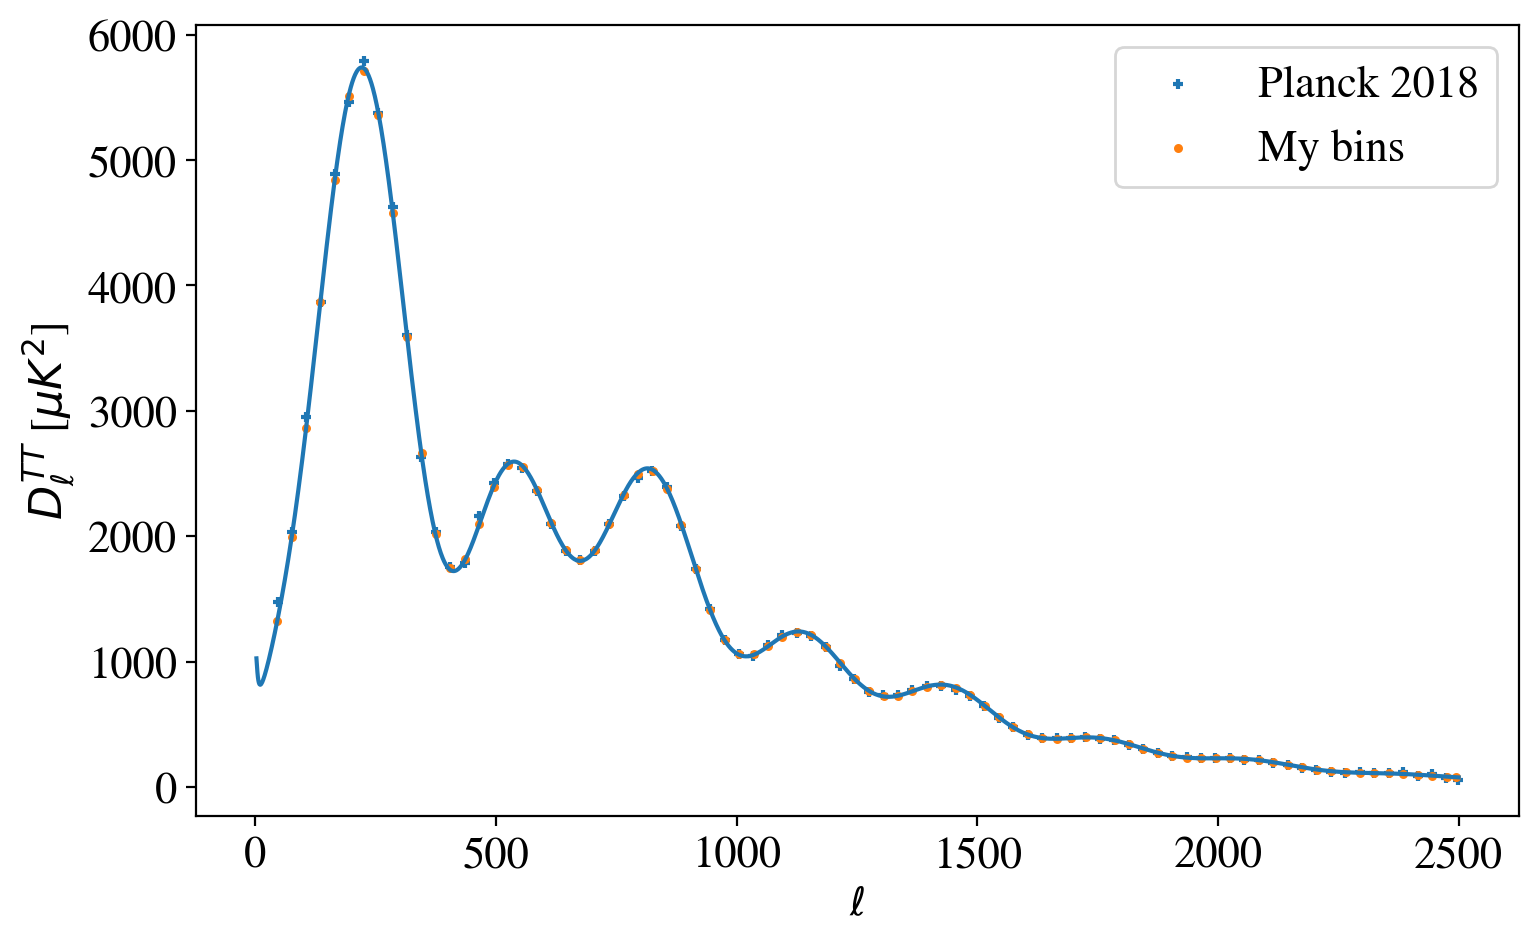

In [7]:
def convert_to_Dl(cl):
    Dl_dict = {}
    for ll, Cl in cl.items():
        Dl_dict[ll] = ll*(ll+1)/(2*np.pi)*Cl
    return Dl_dict

def bin_Dls(dls, deltaL):
    bin_edges = [int(deltaL+i*deltaL) for i in np.arange(np.floor(ll_max/deltaL))]
    bin_edges.append(ll_max)
    Dl_bin={}
    for i,left_edge in enumerate(bin_edges[:-1]):
        left=left_edge
        right=bin_edges[i+1]
        mid = (left+right)/2.
        ## It seems like right+1 double counts contributions from the bin edges
        ## but it matches with planck binned. Remove +1 to match actual line
        lbs = np.arange(left, right+1)
        Db = 0.0
        for l in lbs:
            Db+=dls[l]
        Db/=lbs.shape[0]
        Dl_bin.update({mid: Db})
    
    return np.fromiter(Dl_bin.keys(), dtype=float), np.fromiter(Dl_bin.values(), dtype=float)

fig,ax=plt.subplots(figsize=(8,5))

delta_ell = 30

dl_fid = convert_to_Dl(fiducials['tt'])

dl_bin_centers, tt_dl_binned = bin_Dls(dl_fid, delta_ell)

ax.scatter(data[:,0], data[:,1], s=14, marker='+', label="Planck 2018")
#ax.scatter(bin_centers, bin_centers*(bin_centers+1)/(2*np.pi)*tt_binned, s=5, label="My bins")
ax.scatter(dl_bin_centers, tt_dl_binned, s=5, label="My bins")
ax.plot(ll, ll*(ll+1)/(2*np.pi)*np.fromiter(fiducials['tt'].values(), dtype=float))
ax.set_xlabel("$\ell$", fontsize=14)
ax.set_ylabel("$D^{TT}_\ell$ [$\mu K^2$]")

plt.tight_layout()
plt.legend()
plt.show()

[1.20717294e-03 7.03717332e-04 5.00454084e-04 3.88446765e-04
 3.17231907e-04 2.67672662e-04 2.31494209e-04 2.04895335e-04
 1.85664488e-04 1.71898424e-04 1.61286003e-04 1.51236152e-04
 1.40328660e-04 1.28729346e-04 1.17583044e-04 1.08474420e-04
 1.01592661e-04 9.63732573e-05 9.23473466e-05 8.89448610e-05
 8.56715698e-05 8.21751354e-05 7.84441860e-05 7.46582698e-05
 7.12105442e-05 6.83711034e-05 6.61589011e-05 6.44511565e-05
 6.33276053e-05 6.28712690e-05 6.28868162e-05 6.29825955e-05
 6.26306490e-05 6.13965328e-05 5.94298328e-05 5.73826130e-05
 5.59005132e-05 5.53220741e-05 5.58344392e-05 5.85043338e-05
 5.97444194e-05 6.09308456e-05 6.14689091e-05 6.10361746e-05
 5.99872441e-05 5.89991224e-05 5.86711060e-05 5.94447940e-05
 6.17360423e-05 6.60706146e-05 7.30148614e-05 8.25319877e-05
 9.32215736e-05 1.02401580e-04 1.08491910e-04 1.12723086e-04
 1.17993171e-04 1.27270926e-04 1.43583086e-04 1.70396742e-04
 2.11459772e-04 2.68647433e-04 3.38031955e-04 4.08998594e-04
 4.72463156e-04 5.512310

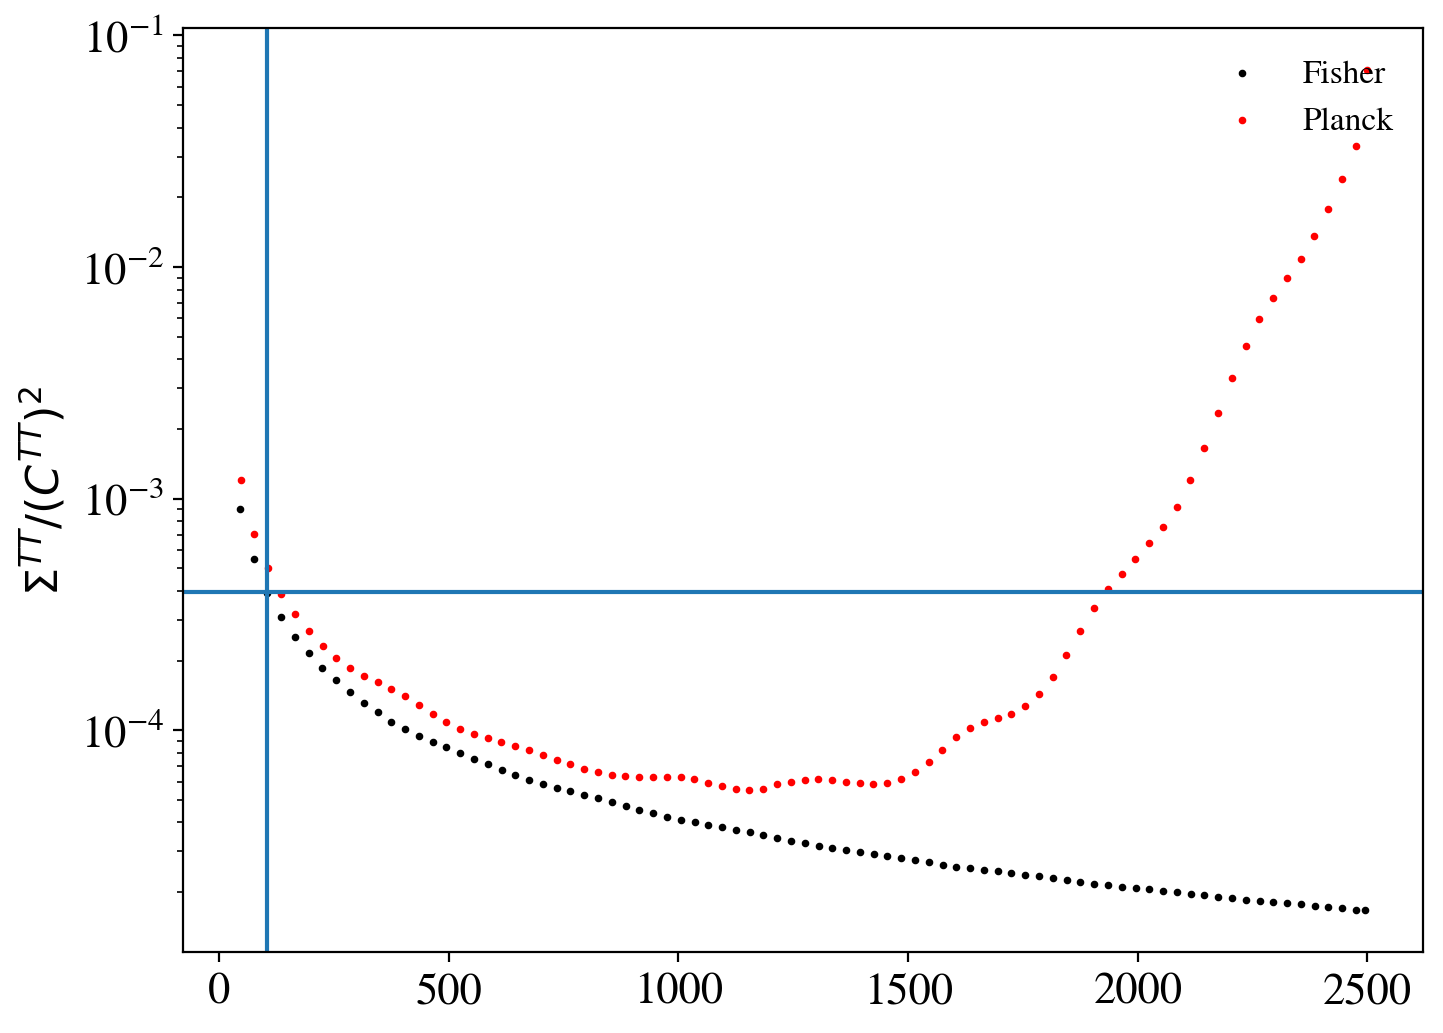

In [9]:
fiducial_Dl = {}

for xx, Cls in fiducials.items():
    fiducial_Dl[xx] = convert_to_Dl(Cls)

def get_planck_binned(file):
    data = np.loadtxt(file)

    ll_arr =data[:,0]
    Dl_arr = data[:,4]
    delta_Dl_arr = (data[:,2] + data[:,3])/2

    return np.array(ll_arr), np.array(Dl_arr), np.array(delta_Dl_arr)

delta_ell = 30

tt_dl_bin_centers, tt_dl_binned = bin_Dls(fiducial_Dl['tt'], delta_ell)
planck_bin_center, planck_dl, planck_delta_dl = get_planck_binned(filelist[0])

error = []

for ell_cent in tt_dl_bin_centers:
    error.append(ell_cent*(ell_cent+1)/(2*np.pi)*np.sqrt(error_covariance[int(ell_cent)-2, 0, 0]/delta_ell))

print(np.array((planck_delta_dl/planck_dl))**2)


fig,ax = plt.subplots()
fsky = 0.8
ax.scatter(tt_dl_bin_centers, (error/tt_dl_binned)**2, color='k', s=3, label="Fisher")
ax.scatter(planck_bin_center, (planck_delta_dl/planck_dl)**2, color='r', s=3, label="Planck")
ax.axhline((1./30)*(2./(2*105 + 1)/fsky))
ax.axvline(105)
#ax.set_xlim([2,200])
ax.legend(loc='upper right', prop={'size': 12}, frameon=False)
ax.set_yscale('log')
ax.set_ylabel("{}".format(labellist[0]))
#plt.savefig("../results/planck_noise_fwhm.pdf", dpi=300, bbox_inches='tight')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[1016.73    963.727   912.608  ...   77.1691   76.9485   76.7311]


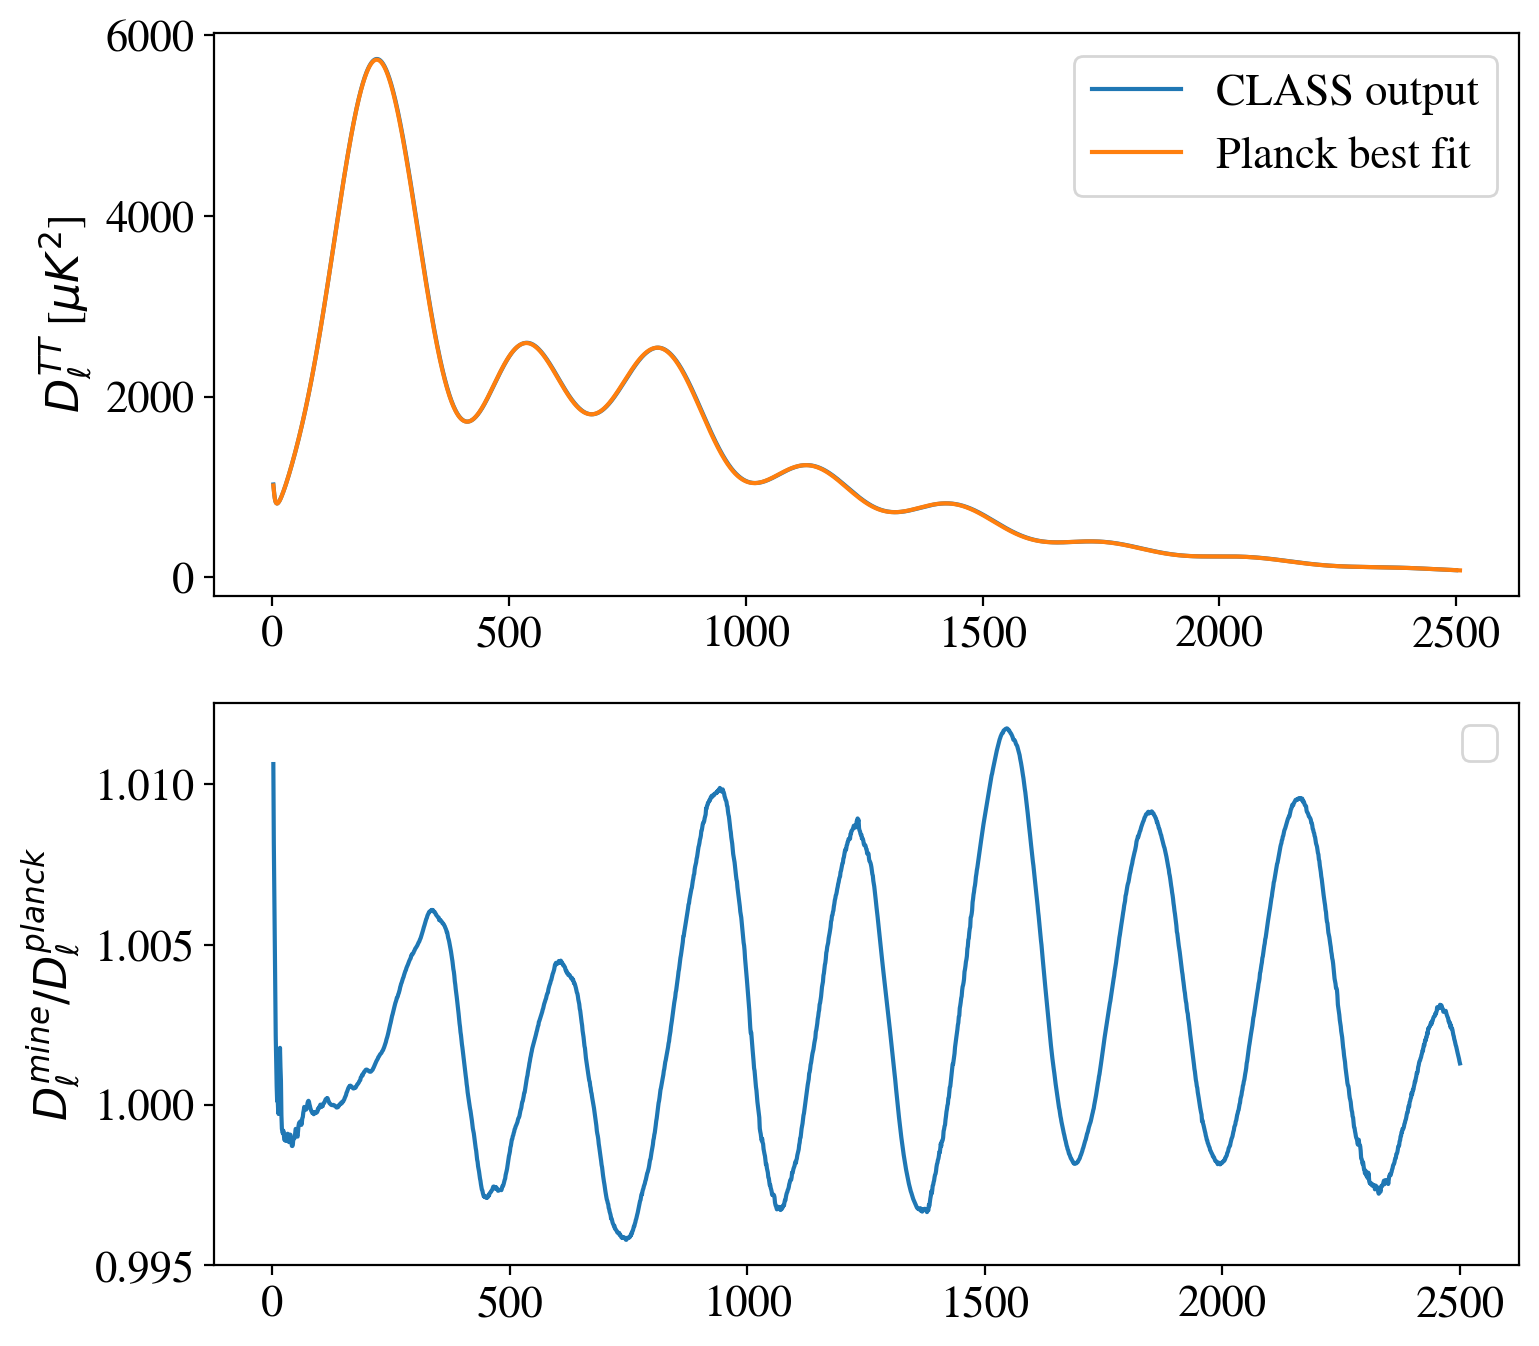

In [9]:
TT_full_file = "/Users/gabe/projects/recombination/data/planck/COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01.txt"

data = np.loadtxt(TT_full_file)
ll_full = data[:,0]
dl_full = data[:,1]

print(dl_full)

fig,ax=plt.subplots(2,1,figsize=(8,7))

ax[0].plot(ll, list(fiducial_Dl['tt'].values()), label="CLASS output")
ax[0].plot(ll_full, dl_full, label="Planck best fit")
ax[0].set_ylabel("$D_\ell^{TT}$ [$\mu K^2$]")

ax[0].legend()

ax[1].plot(ll, list(fiducial_Dl['tt'].values())/dl_full[:2499])
ax[1].set_ylabel("$D^{mine}_\ell / D^{planck}_\ell$")


plt.tight_layout()
plt.legend()
plt.show()


In [80]:
TT_full_file = "/Users/gabe/projects/recombination/data/planck/COM_PowerSpect_CMB-TT-full_R3.01.txt"

data = np.loadtxt(TT_full_file)

l = data[:,0]
Dl = data[:,1]
Dlm = data[:,2]
Dlp = data[:,3]

planck_err = (Dlm + Dlp)/2

print(l[103])

my_err = 105*(105+1)/(2*np.pi)*np.sqrt(error_covariance[int(105)-2, 0, 0])
my_Dl = fiducial_Dl['tt'][105]
print(my_Dl)

print("l = 105")
print("Planck (delta_Dl / Dl)^2 = {}".format((planck_err[103]/Dl[103])**2))
print("My (delta_Dl / Dl)^2 = {}".format((my_err/my_Dl)**2))


105.0
2856.1629725640914
l = 105
Planck (delta_Dl / Dl)^2 = 0.029185820612908947
My (delta_Dl / Dl)^2 = 0.01185133639497669


In [11]:
if True:
    print("one")
elif True:
    print("true")

one


# Planck Error Redux